In [ ]:
# Logistic Regression - Oral Cancer Prediction

In [1]:
#Install & Import Libraries (Run this first!)
!pip install scikit-learn statsmodels --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
#Load Dataset
from google.colab import files
import io

# Upload file
uploaded = files.upload()

# Get the uploaded file
file_name = list(uploaded.keys())[0]
print(f"Uploaded file: {file_name}")

# Read the CSV file
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Saving oral_cancer_prediction_preprocessed_dataset_new.csv to oral_cancer_prediction_preprocessed_dataset_new.csv
Uploaded file: oral_cancer_prediction_preprocessed_dataset_new.csv
Dataset loaded successfully!
Dataset shape: (82715, 16)

First 5 rows:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,Oral Cancer (Diagnosis)
0,-0.699575,0.313334,0.560447,-0.336918,-1.106020,-0.598798,-1.297696,-0.724275,-1.637012,-0.821648,-0.459853,-1.457710,-1.369914,-0.223944,-0.056514,0
1,0.673053,-0.184050,0.576740,1.757344,0.923448,0.746739,0.469264,1.723204,1.723343,0.136200,-0.024877,-1.790372,-1.337522,-0.206183,-0.059692,1
2,0.048024,-1.360864,-0.405148,-1.030663,0.777152,-0.456549,-1.895424,1.622114,-1.418006,0.072663,-0.075828,-1.864626,0.332051,0.028287,0.092806,1
3,1.604668,1.710142,-1.364305,-0.267710,-1.416786,0.038920,1.422042,0.459523,0.031274,-0.796306,-0.435965,-0.193531,0.313675,-0.175422,0.107717,0
4,-2.382625,-1.884699,-0.133362,0.650046,-0.265694,-1.245969,1.377394,0.832647,1.254113,0.252565,-0.999554,-0.251933,0.640998,0.796805,-0.034788,1


In [3]:
#Data Exploration
print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

# Check for target column
possible_targets = [c for c in df.columns if 'oral' in c.lower() or 'target' in c.lower() or 'diagnos' in c.lower() or 'label' in c.lower() or 'cancer' in c.lower()]
target = possible_targets[0] if len(possible_targets) > 0 else df.columns[-1]
print(f"\nUsing target column: '{target}'")
print(f"Target distribution:\n{df[target].value_counts()}")
print(f"Target proportion:\n{df[target].value_counts(normalize=True)}")

Dataset Information:
Shape: (82715, 16)
Columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'Oral Cancer (Diagnosis)']

Data types:
PC1                        float64
PC2                        float64
PC3                        float64
PC4                        float64
PC5                        float64
PC6                        float64
PC7                        float64
PC8                        float64
PC9                        float64
PC10                       float64
PC11                       float64
PC12                       float64
PC13                       float64
PC14                       float64
PC15                       float64
Oral Cancer (Diagnosis)      int64
dtype: object

Missing values:
PC1                        0
PC2                        0
PC3                        0
PC4                        0
PC5                        0
PC6                        0
PC7                        0
PC8  

In [4]:
#Prepare Features (X) and Target (y)
X = df.drop(columns=[target])
y = df[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle categorical variables
non_numeric = X.select_dtypes(include=['object','category']).columns.tolist()
if non_numeric:
    print(f"Encoding categorical columns: {non_numeric}")
    X = pd.get_dummies(X, drop_first=True)
    print(f"Features after encoding: {X.shape}")
else:
    print("All features are numeric.")

print(f"\nFinal feature names: {list(X.columns)}")

Features shape: (82715, 15)
Target shape: (82715,)
All features are numeric.

Final feature names: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15']


In [5]:
#Train-Test Split and Feature Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split and scaled successfully")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Training target distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test target distribution: {pd.Series(y_test).value_counts().to_dict()}")

Data split and scaled successfully
Train shape: (66172, 15)
Test shape: (16543, 15)
Training target distribution: {1: 34374, 0: 31798}
Test target distribution: {1: 8594, 0: 7949}


In [6]:
#Baseline Logistic Regression Model
print("Training Baseline Logistic Regression Model...")

base_model = LogisticRegression(max_iter=1000, random_state=42)
base_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = base_model.predict(X_test_scaled)
y_proba = base_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

print("Baseline Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

Training Baseline Logistic Regression Model...
Baseline Performance:
Accuracy: 0.5195
Precision: 0.5195
Recall: 0.9998
F1 Score: 0.6837
ROC-AUC: 0.5031

Confusion Matrix:
[[   2 7947]
 [   2 8592]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      7949
           1       0.52      1.00      0.68      8594

    accuracy                           0.52     16543
   macro avg       0.51      0.50      0.34     16543
weighted avg       0.51      0.52      0.36     16543



In [7]:
#Hyperparameter Tuning using GridSearchCV
print("Performing Hyperparameter Tuning...")

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    LogisticRegression(max_iter=2000, random_state=42),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid.best_params_}")

# Best model predictions
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
y_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for tuned model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, zero_division=0)
recall_best = recall_score(y_test, y_pred_best, zero_division=0)
f1_best = f1_score(y_test, y_pred_best, zero_division=0)
roc_auc_best = roc_auc_score(y_test, y_proba_best)

print("\nTuned Model Performance:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")
print(f"ROC-AUC: {roc_auc_best:.4f}")

print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_best)}")

Performing Hyperparameter Tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}

Tuned Model Performance:
Accuracy: 0.5195
Precision: 0.5195
Recall: 1.0000
F1 Score: 0.6838
ROC-AUC: 0.5000

Confusion Matrix:
[[   0 7949]
 [   0 8594]]


Analyzing Feature Importance...
Top 15 Most Important Features:


,Feature,Coefficient,Odds_Ratio,Abs_Coefficient
0,PC1,0.0,1.0,0.0
1,PC2,0.0,1.0,0.0
2,PC3,0.0,1.0,0.0
3,PC4,0.0,1.0,0.0
4,PC5,0.0,1.0,0.0
5,PC6,0.0,1.0,0.0
6,PC7,0.0,1.0,0.0
7,PC8,0.0,1.0,0.0
8,PC9,0.0,1.0,0.0
9,PC10,0.0,1.0,0.0


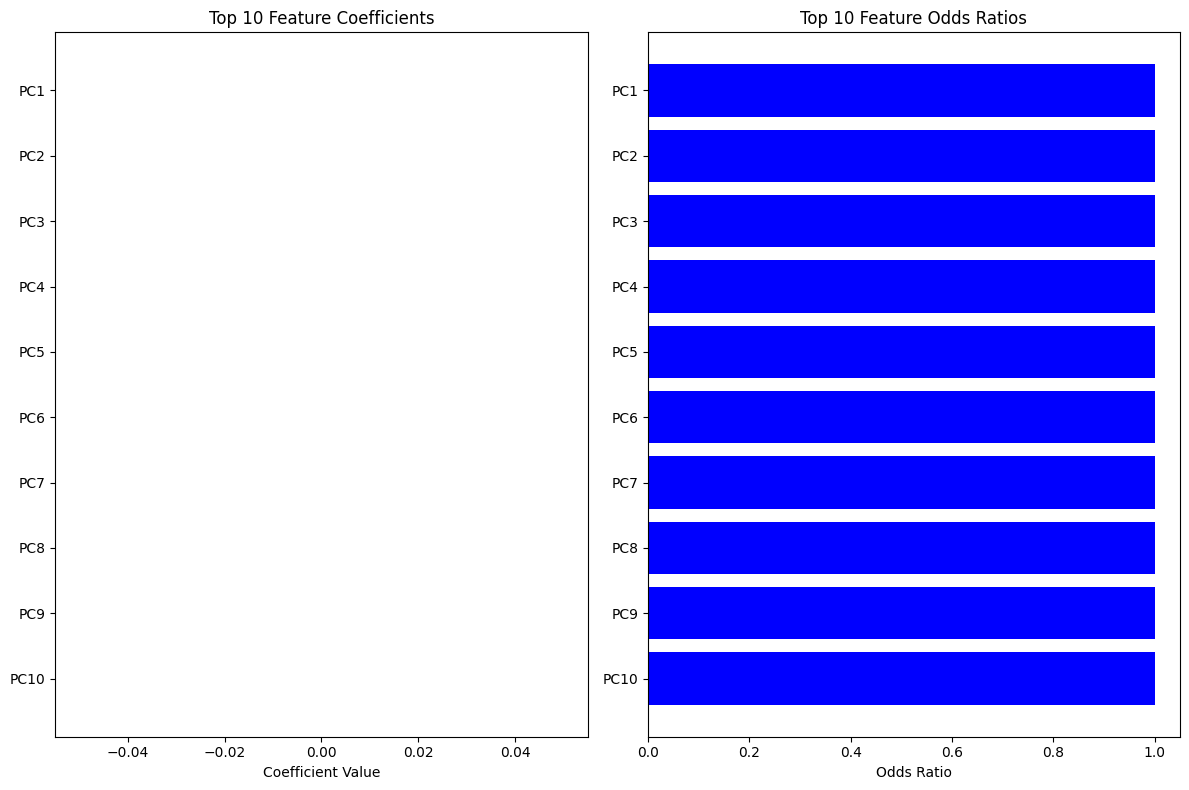

In [8]:
#Coefficients and Odds Ratios
print("Analyzing Feature Importance...")

coef = best_model.coef_.flatten()
features = X.columns
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("Top 15 Most Important Features:")
display(coef_df.head(15))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = coef_df.head(10)
colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]

plt.subplot(1, 2, 1)
plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(top_features['Feature'], top_features['Odds_Ratio'], color=colors)
plt.xlabel('Odds Ratio')
plt.title('Top 10 Feature Odds Ratios')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [9]:
#Multicollinearity Check (VIF)
print("Checking for Multicollinearity (VIF)...")

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_scaled_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_scaled_df.values, i)
                   for i in range(X_train_scaled_df.shape[1])]

vif_data = vif_data.sort_values(by='VIF', ascending=False)

print("VIF Values (Higher than 10 indicates multicollinearity):")
display(vif_data.head(15))

# Highlight high VIF values
high_vif = vif_data[vif_data['VIF'] > 10]
if not high_vif.empty:
    print(f"Warning: {len(high_vif)} features with VIF > 10:")
    print(high_vif[['Feature', 'VIF']])
else:
    print("No multicollinearity issues detected (all VIF < 10)")

Checking for Multicollinearity (VIF)...
VIF Values (Higher than 10 indicates multicollinearity):


,Feature,VIF
8,PC9,1.000075
1,PC2,1.000069
13,PC14,1.000061
7,PC8,1.000051
10,PC11,1.000048
12,PC13,1.000047
14,PC15,1.000044
0,PC1,1.000042
2,PC3,1.000040
6,PC7,1.000037


No multicollinearity issues detected (all VIF < 10)


Generating ROC Curve...


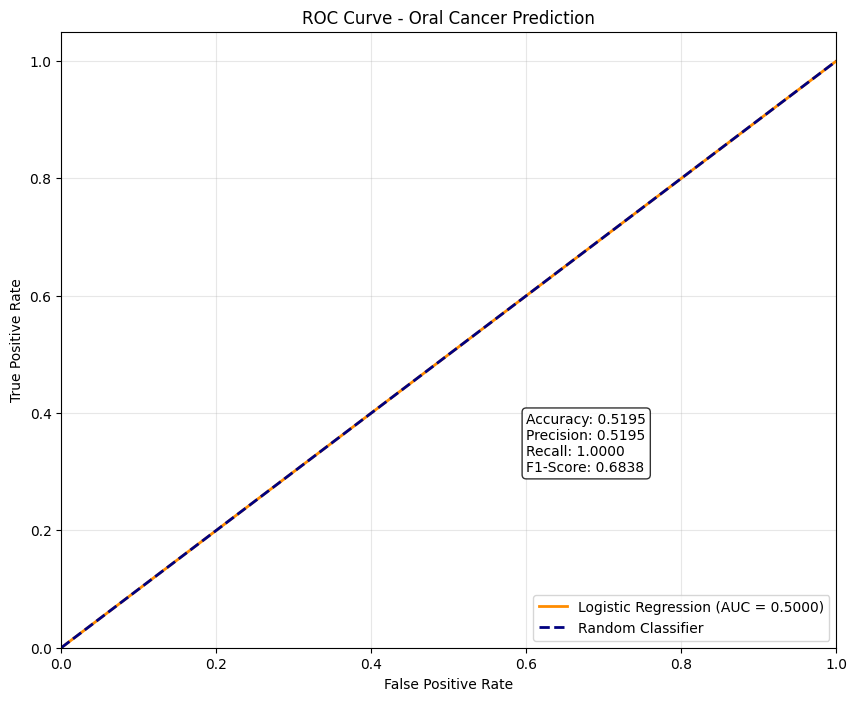

In [10]:
#ROC Curve Visualization
print("Generating ROC Curve...")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
auc_score = roc_auc_score(y_test, y_proba_best)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Oral Cancer Prediction')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Add some metrics to the plot
plt.text(0.6, 0.3, f'Accuracy: {accuracy_best:.4f}\nPrecision: {precision_best:.4f}\nRecall: {recall_best:.4f}\nF1-Score: {f1_best:.4f}',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.show()

In [11]:
#Save Results
print("Saving Results...")

# Save coefficients
coef_df.to_csv("logistic_coefficients.csv", index=False)
print("Saved: logistic_coefficients.csv")

# Save VIF values
vif_data.to_csv("vif_values.csv", index=False)
print("Saved: vif_values.csv")

# Save performance metrics
performance_df = pd.DataFrame({
    'Model': ['Baseline', 'Tuned'],
    'Accuracy': [accuracy, accuracy_best],
    'Precision': [precision, precision_best],
    'Recall': [recall, recall_best],
    'F1_Score': [f1, f1_best],
    'ROC_AUC': [roc_auc, roc_auc_best]
})
performance_df.to_csv("model_performance.csv", index=False)
print("Saved: model_performance.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_best,
    'Probability': y_proba_best
})
predictions_df.to_csv("predictions.csv", index=False)
print("Saved: predictions.csv")

# Download files to your computer
files.download("logistic_coefficients.csv")
files.download("vif_values.csv")
files.download("model_performance.csv")
files.download("predictions.csv")

Saving Results...
Saved: logistic_coefficients.csv
Saved: vif_values.csv
Saved: model_performance.csv
Saved: predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>